# Glenmark Pharmaceuticals Ltd Stock 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("Glenmark Pharmaceuticals Ltd.csv", parse_dates=["Date"], index_col="Date")
df.head(5)

,Open,Close,High,Low,Volume
Date,,,,,
2019-11-01,317.00,315.75,321.80,314.85,1334886
2019-11-04,318.00,316.15,322.95,315.10,812407
2019-11-05,316.15,317.10,321.80,314.65,1161397
2019-11-06,315.50,301.30,317.95,299.05,2341017
2019-11-07,304.00,293.85,304.00,287.30,2794278


### The Date column need to be the index for our Data so that the graphs are plotted accurately
- this will help us retrive data from any specific time period
- this will allow us to resample our data on different bases(weekly,monthly,quarterly,yearly)

In [3]:
df.index

DatetimeIndex(['2019-11-01', '2019-11-04', '2019-11-05', '2019-11-06',
               '2019-11-07', '2019-11-08', '2019-11-11', '2019-11-13',
               '2019-11-14', '2019-11-15',
               ...
               '2024-11-14', '2024-11-18', '2024-11-19', '2024-11-21',
               '2024-11-22', '2024-11-25', '2024-11-26', '2024-11-27',
               '2024-11-28', '2024-11-29'],
              dtype='datetime64[ns]', name='Date', length=1256, freq=None)

### Closing Stock Prices Over The Years

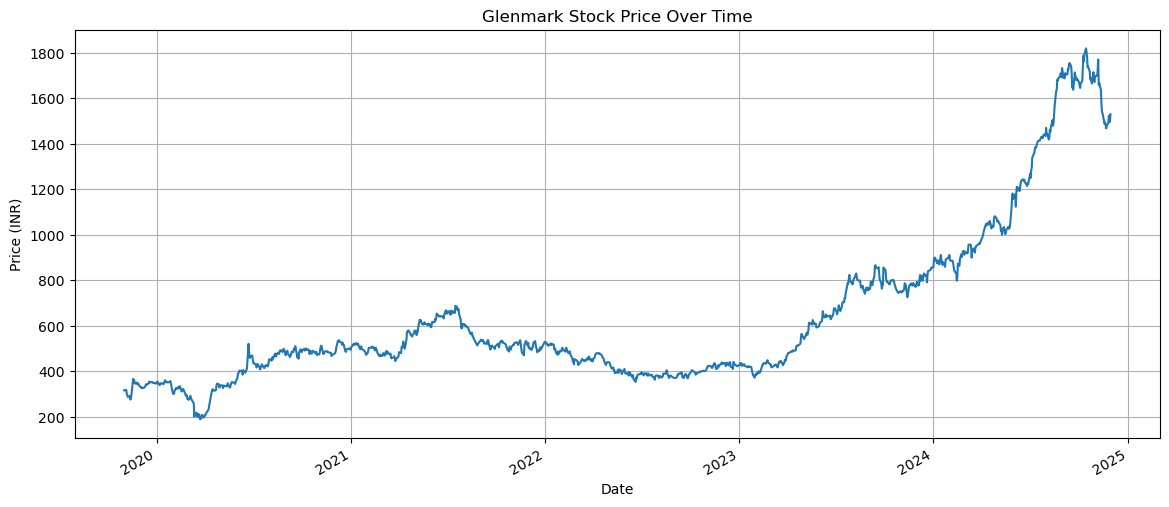

In [4]:
df['Close'].plot(figsize=(14,6), title='Glenmark Stock Price Over Time', ylabel='Price (INR)')
plt.grid(True)

plt.show()


### Average of the Yearly Closing Stock Prices

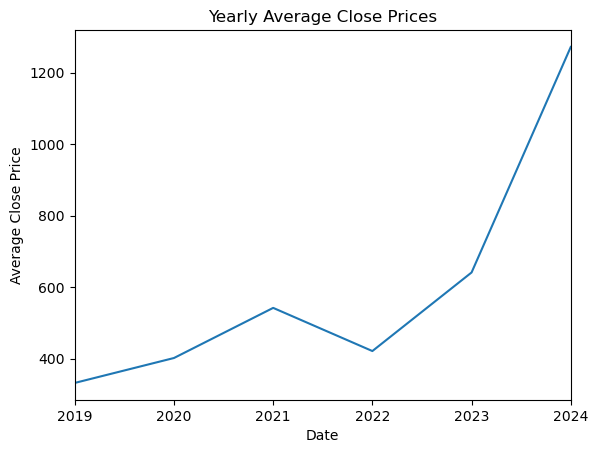

In [5]:
%matplotlib inline

df.Close.resample('Y').mean().plot()
plt.title('Yearly Average Close Prices') 
plt.xlabel('Date') 
plt.ylabel('Average Close Price') 

plt.show()

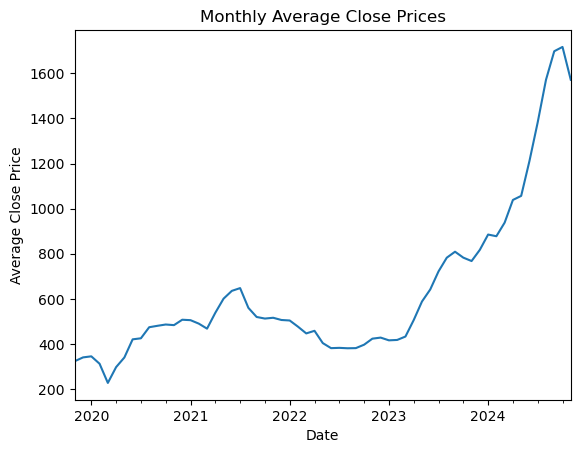

In [24]:
%matplotlib inline

df.Close.resample('M').mean().plot()
plt.title('Monthly Average Close Prices') 
plt.xlabel('Date') 
plt.ylabel('Average Close Price') 

plt.show()

### Average of the Yearly Volume Stock Prices

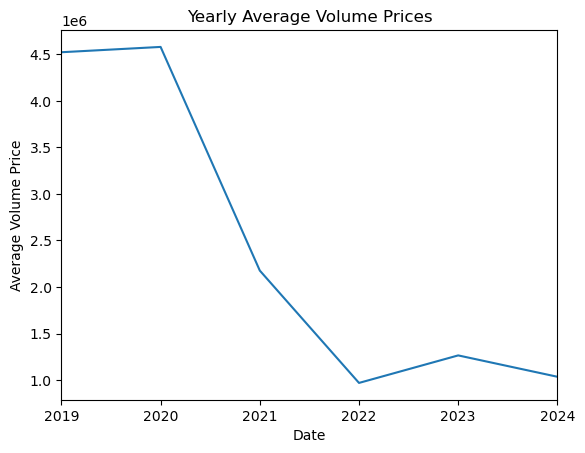

In [23]:
%matplotlib inline

df.Volume.resample('Y').mean().plot()
plt.title('Yearly Average Volume Prices') 
plt.xlabel('Date') 
plt.ylabel('Average Volume Price') 
plt.show()

### Decomposed time series
##### we need to divide the stock prices in 3 parts 
- Trends 
- Seasonality
- Residual

C:\Users\Admin\AppData\Local\Temp\ipykernel_18300\4184470255.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


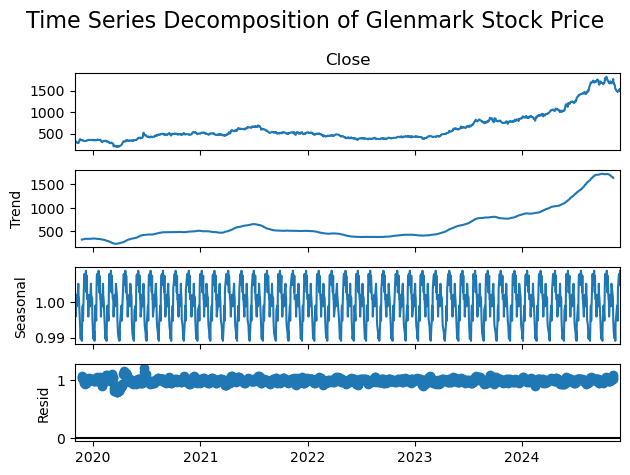

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

series = df['Close']
result = seasonal_decompose(series, model='multiplicative', period=30)
result.plot()
plt.suptitle('Time Series Decomposition of Glenmark Stock Price', fontsize=16)
plt.tight_layout()
plt.show()


#### Close Panel:
There is gradual growth for almost 3 years. Then rapid growth from late 2023 into 2024 visually confirms a non-stationary series with clear upward trend.

---

#### Trend Panel:
The early years are relatively stable.There's a sharp upward trend starting mid-2023. Glenmark experienced consistent growth with a strong uptrend recently possibly due to a product launch, financial results, or market shift.

---

#### Seasonality Panel:
Very regular, wavy pattern around 1.00 with high-frequency oscillation. Likely reflects weekly trading behavior or monthly investor cycles.

---

#### Resid Panel:
Random noise but fairly stable around 1.0. Some mild volatility in early 2020 possibly due to COVID market shock.

### Lets Predict 
#### but before that is the data stable enough to predict

In [7]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['Close'])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic: 1.1366020011644056
p-value: 0.9955172122977443
Critical Value (1%): -3.435571295403709
Critical Value (5%): -2.863845736356174
Critical Value (10%): -2.567997600196822


#### not really lets fix that with differencing

In [8]:
df['Close_diff'] = df['Close'].diff().dropna()

df_diff = df['Close_diff'].dropna()

adf_result_diff = adfuller(df_diff)

print("ADF Statistic (after differencing):", adf_result_diff[0])
print("p-value:", adf_result_diff[1])
for key, value in adf_result_diff[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic (after differencing): -6.867314343372544
p-value: 1.5472295811410922e-09
Critical Value (1%): -3.4356560275160835
Critical Value (5%): -2.8638831211270817
Critical Value (10%): -2.568017509711682


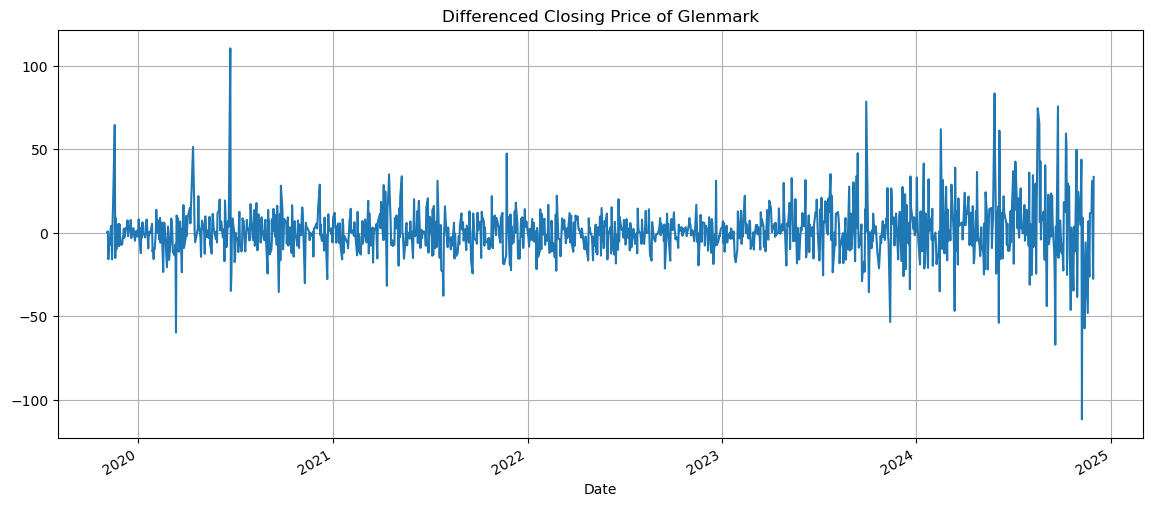

In [9]:
df['Close_diff'].plot(figsize=(14,6), title='Differenced Closing Price of Glenmark')
plt.grid(True)
plt.show()


In [11]:
!pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ac/f8/6c9364602b13f0dba129b53acd1344859690911a4d5021560d9fd6aa087f/pmdarima-2.0.4-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/a2/50/0aa65be5a4ab65bde3224b8fd23ed795f699d1e724ac109bb0a32036b82d/cython-3.1.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
    --------------------------------------- 10.2/614.7 kB ? eta -:--:--
   - ------------------------------------- 30.7/614.7 kB 640.0 kB/s eta 0:00:01
   ------------------------- -------------- 399.4/614.7 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------  614.4/614.7 kB 4.3 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 2.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
    ----------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


### ARIMA model 

In [12]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt

model = auto_arima(df['Close'], 
                   start_p=1, start_q=1,
                   max_p=5, max_q=5,
                   seasonal=False,
                   d=1, 
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10358.669, Time=1.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10355.375, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10357.180, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10357.196, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10358.605, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.716 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1256
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5175.688
Date:                Mon, 30 Jun 2025   AIC                          10355.375
Time:                        14:21:39   BIC                          10365.645
Sample:                             0   HQIC                         10359.235
                               - 1256                                  

### Forecast For Next 30 Trading days

C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


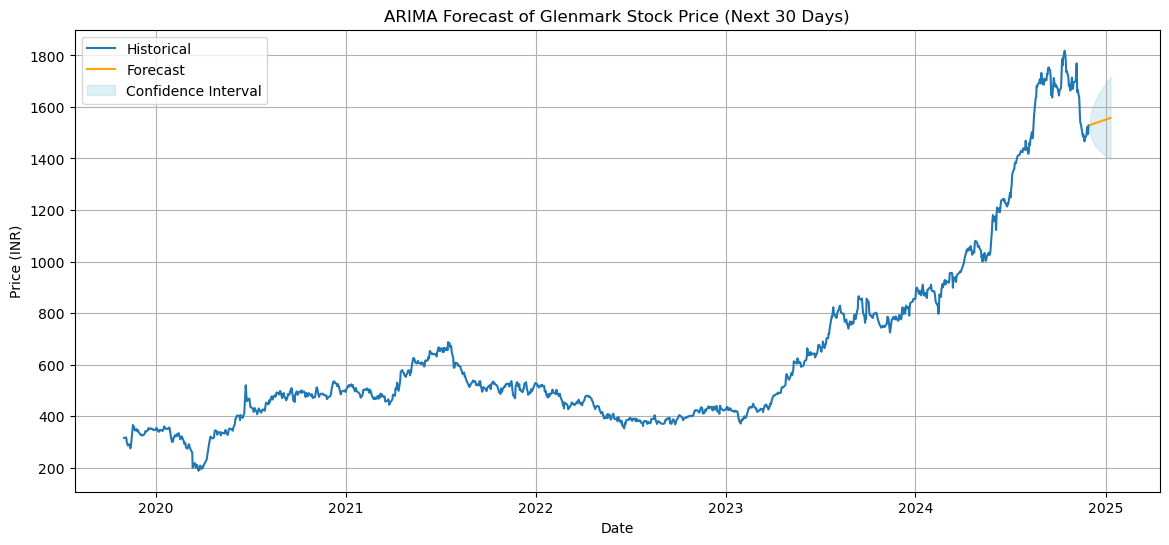

In [13]:
n_periods = 30
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

last_date = df.index[-1]
future_dates = pd.date_range(last_date, periods=n_periods+1, freq='B')[1:]

plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Historical')
plt.plot(future_dates, forecast, label='Forecast', color='orange')
plt.fill_between(future_dates, 
                 conf_int[:, 0], conf_int[:, 1], 
                 color='lightblue', alpha=0.4, label='Confidence Interval')
plt.title('ARIMA Forecast of Glenmark Stock Price (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()


### Interpretation:
The ARIMA model suggests that Glenmark’s stock price is likely to experience a gradual recovery in the short term. Given the absence of significant autoregressive or moving average patterns, the stock price appears to follow a relatively stable trend influenced primarily by past price levels and general market drift.

---

### Business Implication:
The forecast provides a basis for short-term investment decisions and market positioning. While the ARIMA model is effective for trend-based forecasting, future iterations may incorporate external variables or seasonality (e.g., SARIMA or Facebook Prophet) to improve mid- to long-term outlooks.

---

### Conclusion:
The ARIMA-based approach delivers a robust and interpretable short-term forecast for Glenmark Pharmaceuticals. It is particularly suitable for operational and financial decision-making in environments where stability and short-horizon predictability are required.
